**Question 1**

We discussed in class the *Spectral Line Problem* for the data shown in Figure 3.3
and Table 3.1 of our textbook. We computed the unnormalized posterior PDF for the line
strength $T$ , assuming model $M_1$, and got results that match the curves shown in Figure 3.6
for the uniform and Jeffreys priors.

(a) (2 pts) Calculate $p(D|M_1, I)$ for the uniform and Jeffreys prior cases. The numerical
answers are given in (3.45) and (3.47), respectively. There are typos, however, in both
equations (see errata), but the numerical answers are correct. To carry out the integrals,
you can use simple numerical integrators such as `np.trapz` or one of the ”fixed-samples”
methods in `scipy.integrate`.

(b) (2 pts) Calculate the odds ratio $O_{12}$ (Equation 3.31) for the uniform and Jeffreys prior
cases. The numerical answer is given in the text on page 58.

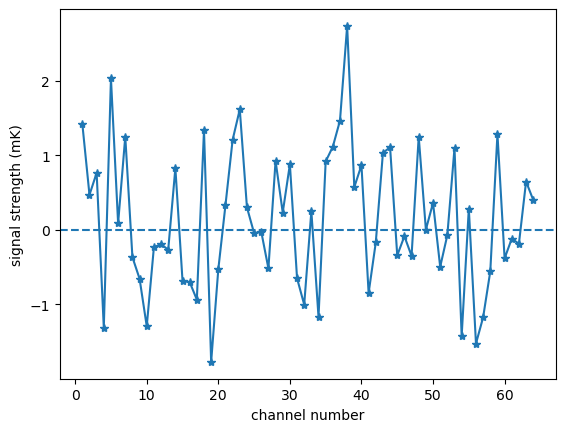

In [147]:
# Copied from SpectralLine1.ipynb

import numpy as np
import matplotlib.pyplot as plt
import scipy

data1 = np.genfromtxt('SpectralLine1.dat')
nu = data1[:, 0]
signal = data1[:, 1]

def plot_spectrum(nu, signal):
    plt.plot(nu, signal, marker='*')
    plt.axhline(y=0, linestyle="--")
    plt.xlabel("channel number")
    plt.ylabel("signal strength (mK)")
    
plot_spectrum(nu, signal)
plt.show()

In [148]:
# Also copied from SpectralLines1.ipynb
def model1(nu, T, nu0=37.0, sigL=2.0):
    """The prediction of model M1 given an array of channel numbers (nu) and
    a specific choice of T for the amplitude of the signal.
    """
    S = T*np.exp(-((nu-nu0)**2)/(2*sigL**2))
    return S

def model2(nu):
    """The prediction of model M2 given an array of channel numbers (nu).
    """
    S = np.zeros_like(nu)  # because we want all the values for each nu
    # S = 0.0*nu           # this should also work
    return S

In [161]:
# Question 1a
import math
def calculate_m1_likelihood_T(nu, signal, T, sigma=1):
    """Calculate p(D|M1, T, I) for a particular value of T, assuming the noise in the data 
    is Gaussian with standard deviation, sigma.
    """
    # Note: You are intended to remove the "raise NotImplementedError()" line along with the
    #       "# YOUR CODE HERE" line and replace both lines with your code.
    N = len(nu)
    model = model1(nu,T)
    LogL = (N/2)*math.log(2*math.pi)+N*math.log(sigma)+(np.sum((signal-model)**2))/(2*sigma*sigma)
    return math.exp(-LogL)
    
def calculate_m1_likelihood(nu, signal, prior, sigma=1, Tmin=0.1, Tmax=100):
    """Calculate p(D|M1, I) assuming the noise in the data is Gaussian with standard deviation, sigma.
    
    If prior is 'uniform', use a uniform prior on T between Tmin and Tmax,
    If prior is 'Jeffreys', use a Jeffreys prior on T between Tmin and Tmax,
    """
    T_values = np.linspace(Tmin, Tmax, 1000)
    likelihood = 0
    if prior == 'uniform':
        likelihood_values = np.array([calculate_m1_likelihood_T(nu, signal, T, sigma) for T in T_values])
        likelihood = np.trapz(likelihood_values, T_values) * (1 / (Tmax - Tmin))
    elif prior == 'Jeffreys':
        likelihood_values = np.array([calculate_m1_likelihood_T(nu, signal, T, sigma) / (1.0*T*np.log(Tmax/Tmin)) for T in T_values])
        likelihood = np.trapz(likelihood_values, T_values)
    return likelihood

In [163]:
p_m1_uniform = calculate_m1_likelihood(nu, signal, 'uniform')
print(f'Uniform prior: p(D|M1,I) = {p_m1_uniform}')

# The book claims this answer is 1.131e-38
assert np.isclose(p_m1_uniform, 1.131e-38, rtol=0.001, atol=0)

p_m1_Jeffreys = calculate_m1_likelihood(nu, signal, 'Jeffreys')
print(f'Jeffreys prior: p(D|M1,I) = {p_m1_Jeffreys}')

# The book claims this answer is 1.239e-37
assert np.isclose(p_m1_Jeffreys, 1.239e-37, rtol=0.001, atol=0)



Uniform prior: p(D|M1,I) = 1.1319643746936368e-38
Jeffreys prior: p(D|M1,I) = 1.2400913719358646e-37


In [151]:
def calculate_m2_likelihood(nu, signal, sigma=1):
    """Calculate p(D|M2, I) assuming the noise in the data is Gaussian with standard deviation, sigma.
    """
    N = len(nu)
    LogL = (N/2)*math.log(2*math.pi)+N*math.log(sigma)+(np.sum((signal)**2))/(2*sigma*sigma)
    return math.exp(-LogL)
def calculate_odds(p1, p2):
    """Calculate the odds ratio given the likelihood of two models.
    """
    return p1/p2

In [152]:
p_m2 = calculate_m2_likelihood(nu, signal)

odds_uniform = calculate_odds(p_m1_uniform, p_m2)
odds_Jeffreys = calculate_odds(p_m1_Jeffreys, p_m2)
print(f'Odds ratio for uniform prior is {odds_uniform}')
print(f'Odds ratio for Jeffreys prior is {odds_Jeffreys}')

# The book claims these are 0.9986 and 10.94
assert np.isclose(odds_uniform, 0.9986, rtol=0.001)
assert np.isclose(odds_Jeffreys, 10.94, rtol=0.001)


Odds ratio for uniform prior is 0.9992029173316915
Odds ratio for Jeffreys prior is 10.946483337265237


**Question 2**

In this problem, we will simulate another data set that resembles the one shown
in Figure 3.7, which has a higher line strength than the first example.

(a) (2 pts) Taking $T = 5.0$ mK, simulate a new dataset $D^\prime$ by sampling the signal in each
channel from a normal (gaussian) distribution with a mean given by the model and
$\sigma = 1.0$ mK. You can use np.random.normal to sample from a normal distribution.
Plot the new dataset and confirm that it roughly resembles the left panel of Figure 3.7.

(b) (2 pts) Using the Jeffreys prior for $T$ in the range $0.1 \le T \le 100$ mK,
calculate the posterior PDF $p(T |D^\prime, M_1, I)$ and the 95% credible region for $T$.
Make a plot of $p(T |D^\prime, M_1, I)$ vs $T$.

(c) (2 pts) Calculate the new odds ratio $O_{12}^\prime$

In [175]:
# Question 2a
def simulate_spectrum(nu, T=5.0, sigma=1):
    """Simlulate a specturm of the M1 model for the given channels (nu), assuming the signal strength
    is T and the noise in the data is sigma.
    
    Returns an array of simulated signal values.
    """
    mean_signal = model1(nu, T)
    simulated_data = np.random.normal(mean_signal, sigma)
    return simulated_data


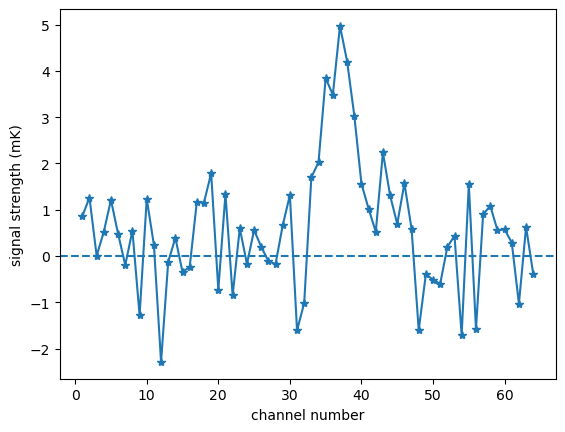

In [177]:
sim = simulate_spectrum(nu)

plot_spectrum(nu, sim)


In [179]:
# Question 2b

def calculate_m1_T_posterior(nu, signal, sigma=1, Tmin=0.1, Tmax=100):
    """Calculate the posterior PDF for T, p(T|D',M1,I) in the M1 model, assuming a Jeffreys prior on T.
    
    Returns T, p(T|D',M1,I) (both numpy arrays; they should be the same length)
    """
    T_values = np.linspace(Tmin, Tmax, 1000)
    likelihood_values = np.array([calculate_m1_likelihood_T(nu, signal, T, sigma) for T in T_values])

    prior_values = 1 / (T_values * np.log(Tmax / Tmin))
    unnormalized_posterior = likelihood_values * prior_values

    normalization_constant = np.trapz(unnormalized_posterior, T_values)
    posterior_values = unnormalized_posterior / normalization_constant
    return T_values, posterior_values
    
def calculate_m1_T_95(T, pdf, C=0.95):
    """Calculate the 95% confidence interval for the given pdf
    
    Returns (T1, T2) being the limits of the confidence interval.
    """
    cdf = scipy.integrate.cumulative_trapezoid(pdf, T, initial=0)
   
    lower_bound = T[np.searchsorted(cdf, (1 - C) / 2)]
    upper_bound = T[np.searchsorted(cdf, 1 - (1 - C) / 2)]
    
    return lower_bound, upper_bound

In [181]:
T, p_T_sim = calculate_m1_T_posterior(nu, sim)

print(f'Maximum posterior is at T = {T[np.argmax(p_T_sim)]:.2f} mK')

T1, T2 = calculate_m1_T_95(T, p_T_sim)
print(f'95% confidence interval: [{T1}, {T2}]')


Maximum posterior is at T = 4.90 mK
95% confidence interval: [3.9000000000000004, 6.0]


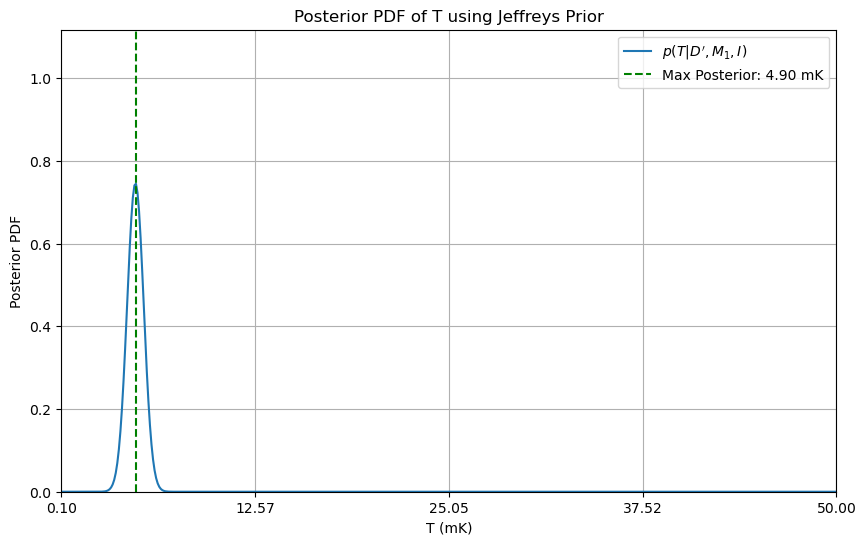

In [183]:
# Question 2b, continued

def plot_T_posterior(T, pdf):
    """Plot the posterior probability distribution function (pdf) of T in model M1 for the simulation.
    """
    # Hint: Make sure to pick a reasonable range for the axes, and label your axes.
    
    plt.figure(figsize=(10, 6))
    plt.plot(T, pdf, label=r'$p(T | D^\prime, M_1, I)$')
    max_posterior_index = np.argmax(pdf)
    max_posterior_T = T[max_posterior_index]
    plt.axvline(max_posterior_T, color='g', linestyle='--', label=f'Max Posterior: {max_posterior_T:.2f} mK')
    plt.xlim(T.min(), 50)
    plt.xticks(np.linspace(T.min(), 50, num=5))  # Fewer X-axis ticks
    plt.ylim(0, np.max(pdf) * 1.5)
    plt.xlabel('T (mK)')
    plt.ylabel('Posterior PDF')
    plt.title('Posterior PDF of T using Jeffreys Prior')
    plt.legend()
    plt.grid(True)
    
plot_T_posterior(T, p_T_sim)
plt.show()

In [198]:
# Question 2c

def calculate_sim_odds(nu, sim, prior='Jeffreys'):
    """Calculate the new odds ration of M1 vs M2 for the simulated data.
    """
    # Hint: You should be able to do this just by calling functions you already wrote above.
    #print(calculate_m1_likelihood(nu,sim,'Jeffery'))
    return calculate_m1_likelihood(nu,sim,'Jeffreys')/calculate_m2_likelihood(nu,sim)

In [200]:
odds_sim = calculate_sim_odds(nu, sim)
print(f'The new odds are {odds_sim:.2e}')


The new odds are 1.82e+17
